<a href="https://colab.research.google.com/github/BaronVonBussin/Stuff/blob/main/GridGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 50/500, Total Reward: -12, Epsilon: 0.778
Episode 100/500, Total Reward: -5, Epsilon: 0.606
Episode 150/500, Total Reward: -4, Epsilon: 0.471
Episode 200/500, Total Reward: 2, Epsilon: 0.367
Episode 250/500, Total Reward: -6, Epsilon: 0.286
Episode 300/500, Total Reward: 1, Epsilon: 0.222
Episode 350/500, Total Reward: 2, Epsilon: 0.173
Episode 400/500, Total Reward: 3, Epsilon: 0.135
Episode 450/500, Total Reward: 3, Epsilon: 0.105
Episode 500/500, Total Reward: 2, Epsilon: 0.082
Policy Grid:
[['D' 'R' 'R' 'D' 'D']
 ['D' 'X' 'R' 'D' 'D']
 ['D' 'L' 'X' 'D' 'D']
 ['D' 'X' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'G']]


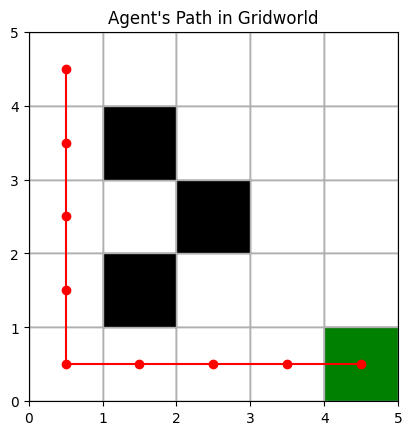

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import random

# Environment Parameters
GRID_SIZE = 5
START = (0, 0)
GOAL = (4, 4)
OBSTACLES = [(1, 1), (2, 2), (3, 1)]
ACTIONS = ['up', 'down', 'left', 'right']
ACTION_DICT = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

class GridworldEnv:
    def __init__(self, grid_size, start, goal, obstacles):
        self.grid_size = grid_size
        self.start = start
        self.agent_pos = start
        self.goal = goal
        self.obstacles = obstacles

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        dx, dy = ACTION_DICT[action]
        x, y = self.agent_pos
        x_new, y_new = x + dx, y + dy

        # Check boundaries
        if 0 <= x_new < self.grid_size and 0 <= y_new < self.grid_size:
            # Check obstacles
            if (x_new, y_new) not in self.obstacles:
                self.agent_pos = (x_new, y_new)

        reward = -1  # Default step cost
        done = False
        if self.agent_pos == self.goal:
            reward = 10
            done = True

        return self.agent_pos, reward, done

    def get_state(self):
        return self.agent_pos

def initialize_q_table(grid_size):
    q_table = {}
    for x in range(grid_size):
        for y in range(grid_size):
            q_table[(x, y)] = {a: 0 for a in ACTIONS}
    return q_table

def choose_action(state, q_table, epsilon):
    if random.uniform(0, 1) < epsilon:
        # Explore: random action
        return random.choice(ACTIONS)
    else:
        # Exploit: best action
        q_values = q_table[state]
        max_q = max(q_values.values())
        actions_with_max_q = [a for a, q in q_values.items() if q == max_q]
        return random.choice(actions_with_max_q)

def update_q_table(q_table, state, action, reward, next_state, alpha, gamma):
    max_future_q = max(q_table[next_state].values())
    current_q = q_table[state][action]
    new_q = current_q + alpha * (reward + gamma * max_future_q - current_q)
    q_table[state][action] = new_q

def plot_policy(q_table, grid_size, obstacles, goal):
    policy_grid = np.full((grid_size, grid_size), ' ')
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == goal:
                policy_grid[x, y] = 'G'
            elif (x, y) in obstacles:
                policy_grid[x, y] = 'X'
            else:
                q_values = q_table[(x, y)]
                max_q = max(q_values.values())
                actions_with_max_q = [a for a, q in q_values.items() if q == max_q]
                policy_grid[x, y] = ''.join([a[0].upper() for a in actions_with_max_q])

    print("Policy Grid:")
    print(policy_grid)

def visualize_grid(env, path):
    fig, ax = plt.subplots()
    # Draw grid
    for x in range(env.grid_size):
        for y in range(env.grid_size):
            rect = patches.Rectangle((y, env.grid_size - x - 1), 1, 1, linewidth=1, edgecolor='gray', facecolor='white')
            ax.add_patch(rect)

    # Draw obstacles
    for (x, y) in env.obstacles:
        rect = patches.Rectangle((y, env.grid_size - x - 1), 1, 1, linewidth=1, edgecolor='gray', facecolor='black')
        ax.add_patch(rect)

    # Draw goal
    x, y = env.goal
    rect = patches.Rectangle((y, env.grid_size - x - 1), 1, 1, linewidth=1, edgecolor='gray', facecolor='green')
    ax.add_patch(rect)

    # Draw path
    x_vals = [pos[1] + 0.5 for pos in path]
    y_vals = [env.grid_size - pos[0] - 0.5 for pos in path]
    ax.plot(x_vals, y_vals, marker='o', color='red')

    # Adjust plot
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks(np.arange(0, env.grid_size+1, 1))
    ax.set_yticks(np.arange(0, env.grid_size+1, 1))
    ax.grid(True)
    ax.set_title("Agent's Path in Gridworld")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def main():
    # Parameters
    num_episodes = 500
    max_steps = 100
    alpha = 0.1   # Learning rate
    gamma = 0.99  # Discount factor
    epsilon = 1.0 # Exploration rate
    epsilon_decay = 0.995
    min_epsilon = 0.01

    env = GridworldEnv(GRID_SIZE, START, GOAL, OBSTACLES)
    q_table = initialize_q_table(env.grid_size)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = choose_action(state, q_table, epsilon)
            next_state, reward, done = env.step(action)
            update_q_table(q_table, state, action, reward, next_state, alpha, gamma)
            state = next_state
            total_reward += reward

            if done:
                break

        # Decay exploration rate
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Optionally print progress
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    # After training, visualize the learned policy
    plot_policy(q_table, env.grid_size, env.obstacles, env.goal)

    # Test the learned policy
    state = env.reset()
    path = [state]
    for _ in range(max_steps):
        action = choose_action(state, q_table, epsilon=0.0)  # Fully exploit
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        if done:
            break

    # Visualize the agent's path
    visualize_grid(env, path)

if __name__ == "__main__":
    main()
